In [1]:
import sys
sys.path.insert(0, "..")

from base_f import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from cross_validation_f import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from cross_validation_f import evaluate_prediction, plot_prediction, plot_anomalies
from cross_validation_f import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from cross_validation_f import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

nb_name = ''

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [4]:
daily_input

,T,T5,T25,T75,T95,E,E5,E25,E75,E95,...,P5,P25,P75,P95,S,S5,S25,S75,S95,Q
1979-01-01,267.030800,259.423965,264.770370,269.903666,271.393407,0.181577,-0.026950,0.065003,0.295771,0.401061,...,1.353607e+00,1.903010,3.305811,6.320868,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-02,256.239496,248.319887,253.454719,259.598266,261.014715,0.286165,0.098759,0.182405,0.388019,0.535194,...,2.977223e-02,0.094753,0.370587,1.454239,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-03,253.756834,248.119540,252.206121,256.035496,257.306931,0.047656,-0.059154,-0.008856,0.097353,0.170551,...,6.420172e-04,0.004360,0.380750,2.935955,0.352941,0.0,0.00,0.00,2.00,NaN
1979-01-04,253.463380,247.050256,251.478882,256.005230,257.660182,0.004512,-0.084268,-0.041746,0.048608,0.108869,...,1.555252e-05,0.000112,0.014688,0.238525,0.357843,0.0,0.00,0.00,2.00,NaN
1979-01-05,254.954417,248.519806,252.222736,258.251339,261.114486,-0.014500,-0.142154,-0.087223,0.057861,0.148606,...,0.000000e+00,0.000018,0.005194,0.067228,0.357843,0.0,0.00,0.00,2.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,271.168567,266.736515,270.145703,272.652775,273.825812,0.001966,-0.242790,-0.149373,0.140196,0.353434,...,8.230788e-01,1.345748,4.668637,11.687098,111.031863,0.0,2.00,200.50,424.65,347.171
2019-12-28,269.013516,263.122302,267.543209,271.277210,272.116384,0.429027,-0.030195,0.224833,0.651166,0.971795,...,5.321469e-04,0.002642,0.081275,0.933446,111.012255,0.0,2.00,200.50,425.30,298.279
2019-12-29,267.255354,261.060061,265.707292,269.498849,270.606458,0.415245,-0.166784,0.103196,0.685523,1.006980,...,-8.745365e-09,0.000000,0.000060,0.000303,110.865196,0.0,1.75,199.75,425.30,296.833
2019-12-30,268.142019,264.366301,266.964908,269.720688,270.772228,0.101724,-0.275798,-0.122921,0.319573,0.576469,...,-3.098491e-07,0.000000,0.000000,0.000000,110.828431,0.0,1.75,199.75,425.30,268.463


In [5]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)


C_range=np.logspace(-1.2, 0.5, 10)
epsilon_range=np.logspace(-2.2, -0.2, 4)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=730

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits

C=1.3250193550567484
eps=0.6309573444801932


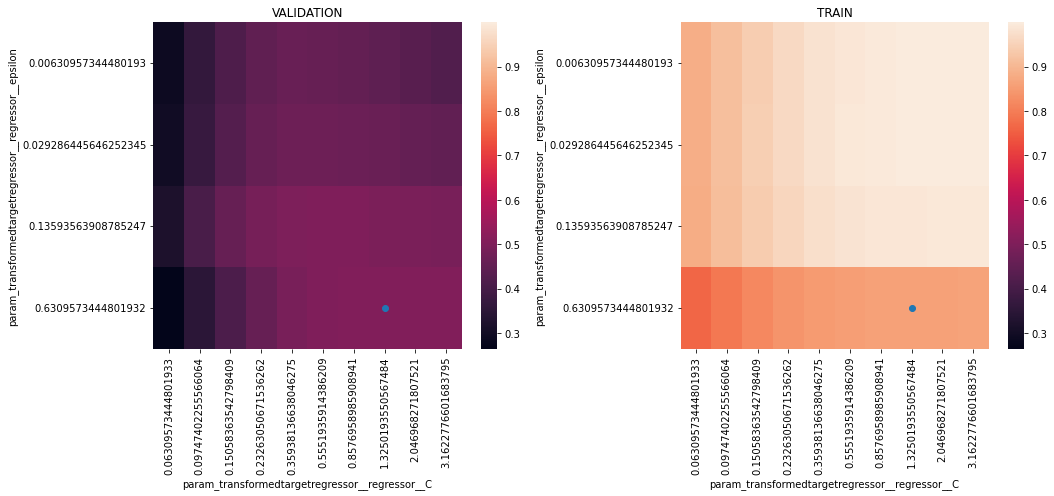

In [9]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [10]:
C_range=np.logspace(-0.4, 0.5, 6)
epsilon_range=np.logspace(-0.2, 0.1, 4)

Fitting 1 folds for each of 24 candidates, totalling 24 fits
Fitting 1 folds for each of 24 candidates, totalling 24 fits
Fitting 1 folds for each of 24 candidates, totalling 24 fits
Fitting 1 folds for each of 24 candidates, totalling 24 fits

C=1.3803842646028848
eps=0.6309573444801932


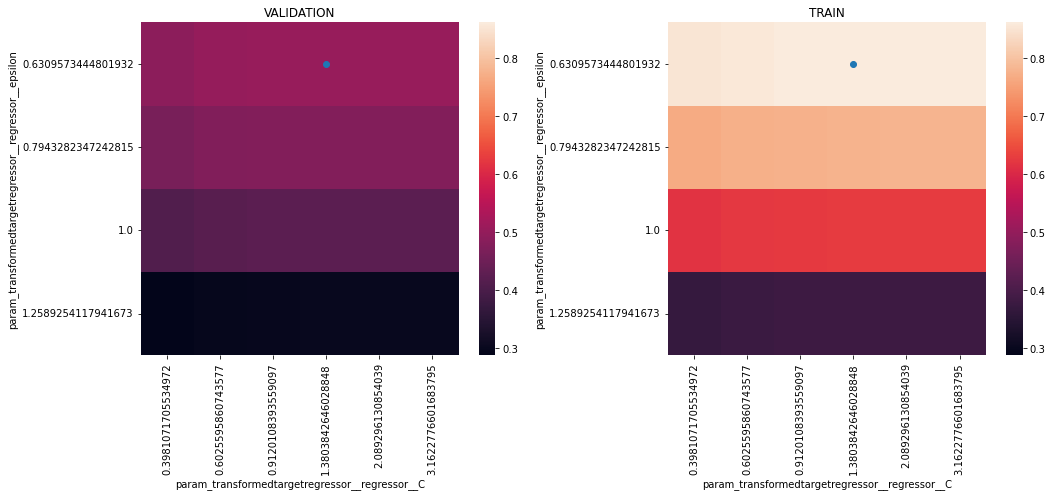

In [11]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [6]:
C=1.3803842646028848
eps=0.6309573444801932

In [7]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

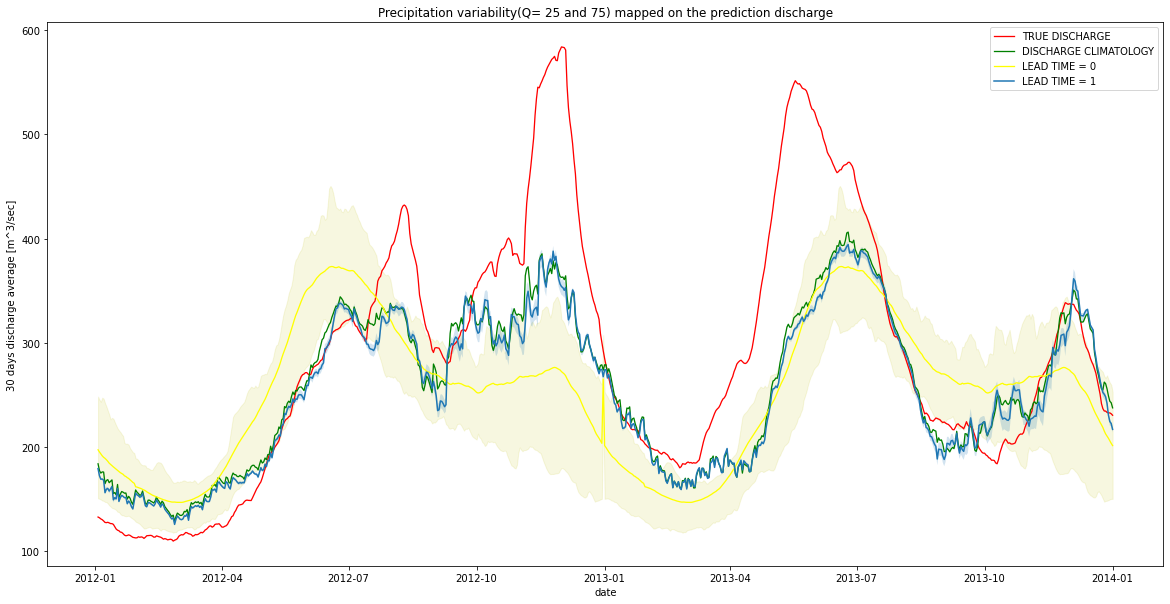

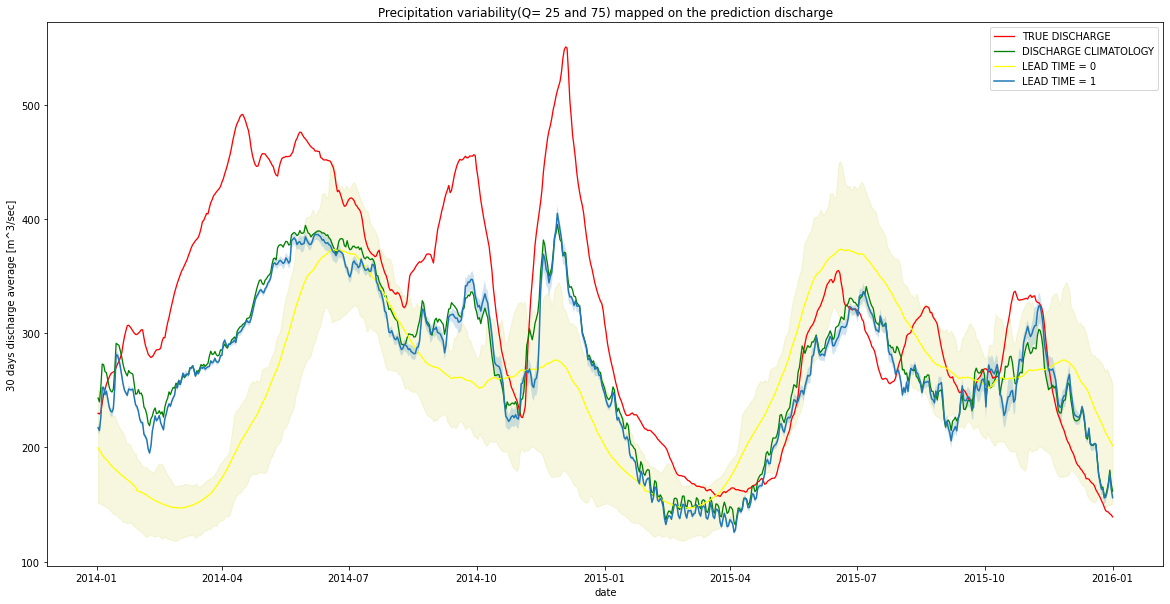

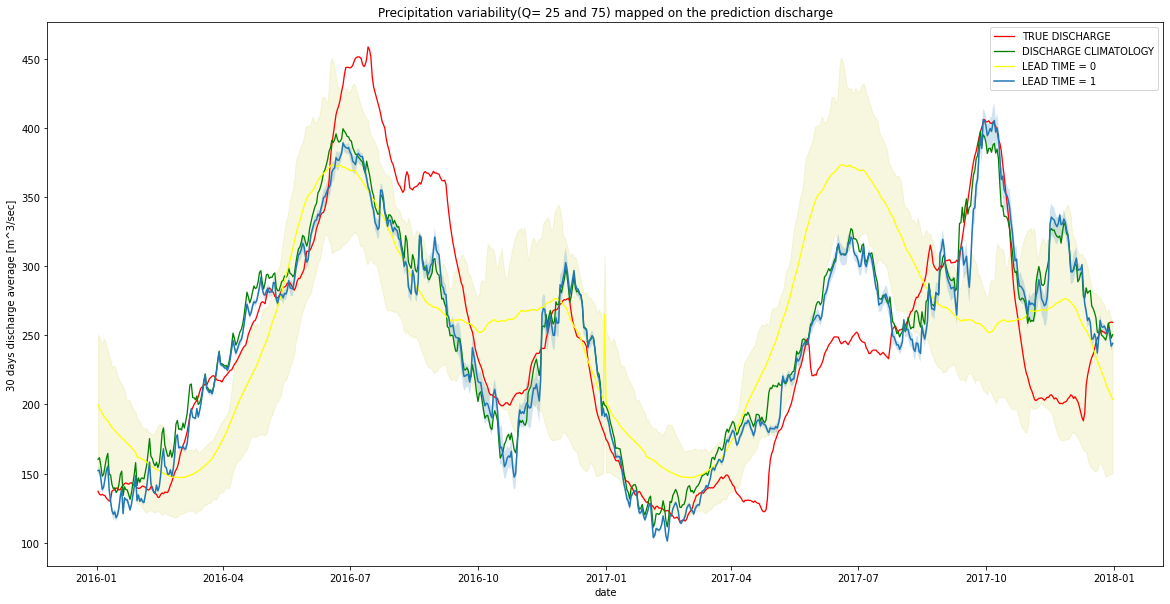

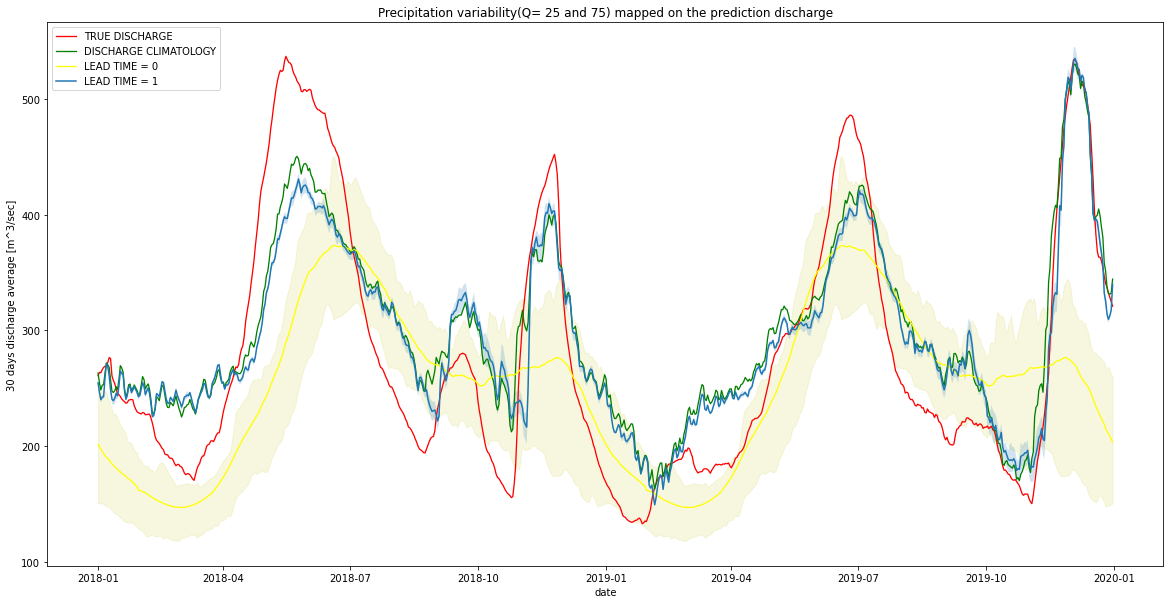

In [8]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


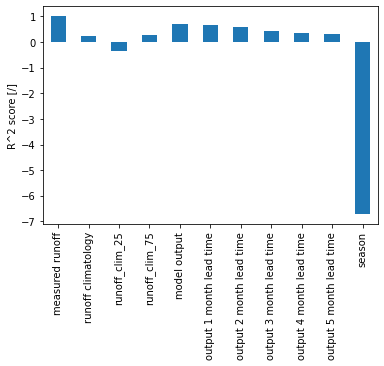

In [10]:
from cross_validation_f import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

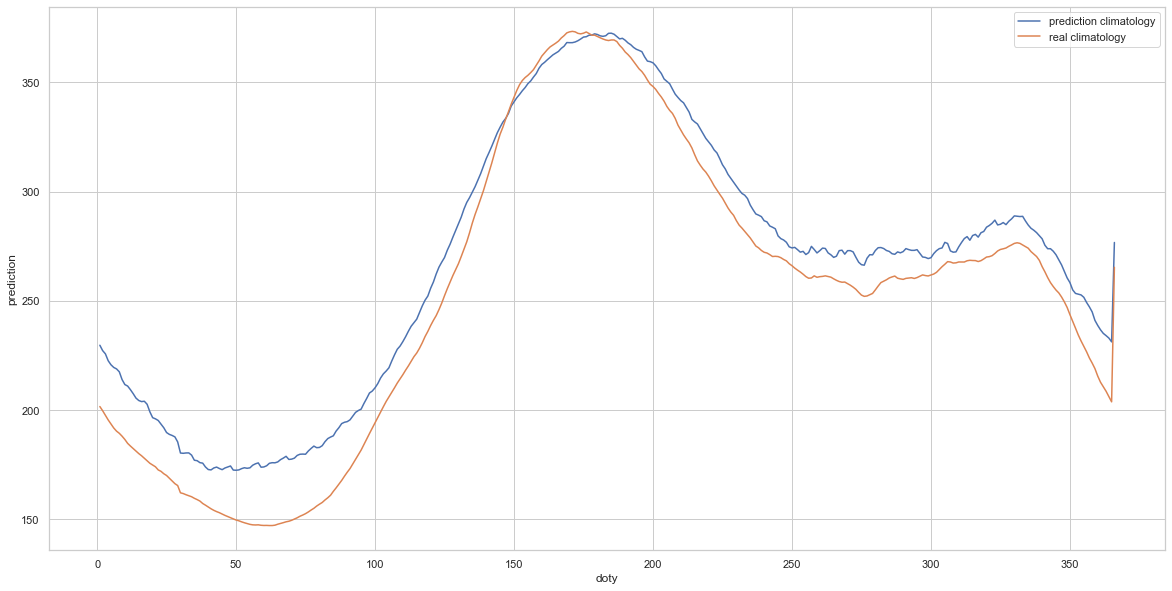

In [11]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()


from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [12]:
##develop model savior

from sklearn.svm import SVR, LinearSVR
from base_f import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_SI03_0033.joblib']